In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Define the transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root='./Dataset', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the DataLoader
for images, labels in dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4960184].


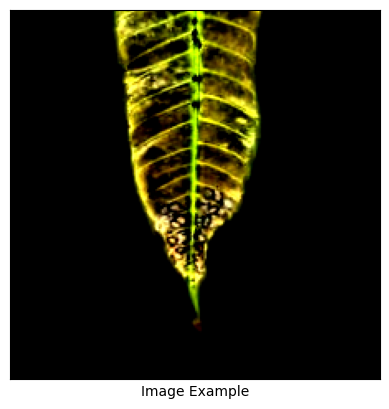

In [2]:
import matplotlib.pyplot as plt

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Image Example')
    plt.show()

# Display the first batch of images
imshow(dataloader.dataset[0][0])

/home/kafi/miniforge3/envs/mango/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kafi/miniforge3/envs/mango/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/kafi/miniforge3/envs/mango/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also u

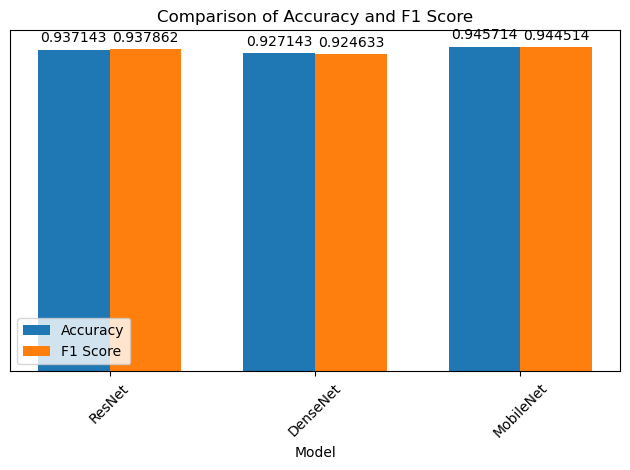

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torchvision import models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a function to train and evaluate a model
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

# Initialize models, criterion, and optimizer
models_dict = {
    'ResNet': models.resnet18(pretrained=True),
    'DenseNet': models.densenet121(pretrained=True),
    'MobileNet': models.mobilenet_v2(pretrained=True)
}

for model_name, model in models_dict.items():
    if model_name == 'ResNet':
        model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))
    elif model_name == 'DenseNet':
        model.classifier = nn.Linear(model.classifier.in_features, len(dataset.classes))
    elif model_name == 'MobileNet':
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset.classes))
    models_dict[model_name] = model

criterion = nn.CrossEntropyLoss()

results = {}
for model_name, model in models_dict.items():
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    accuracy, f1 = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)
    results[model_name] = {'accuracy': accuracy, 'f1_score': f1}

# Plot the results
labels = list(results.keys())
accuracy_values = [results[label]['accuracy'] for label in labels]
f1_values = [results[label]['f1_score'] for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_values, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_title('Comparison of Accuracy and F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add cute elements to the bar chart
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.yticks([])
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

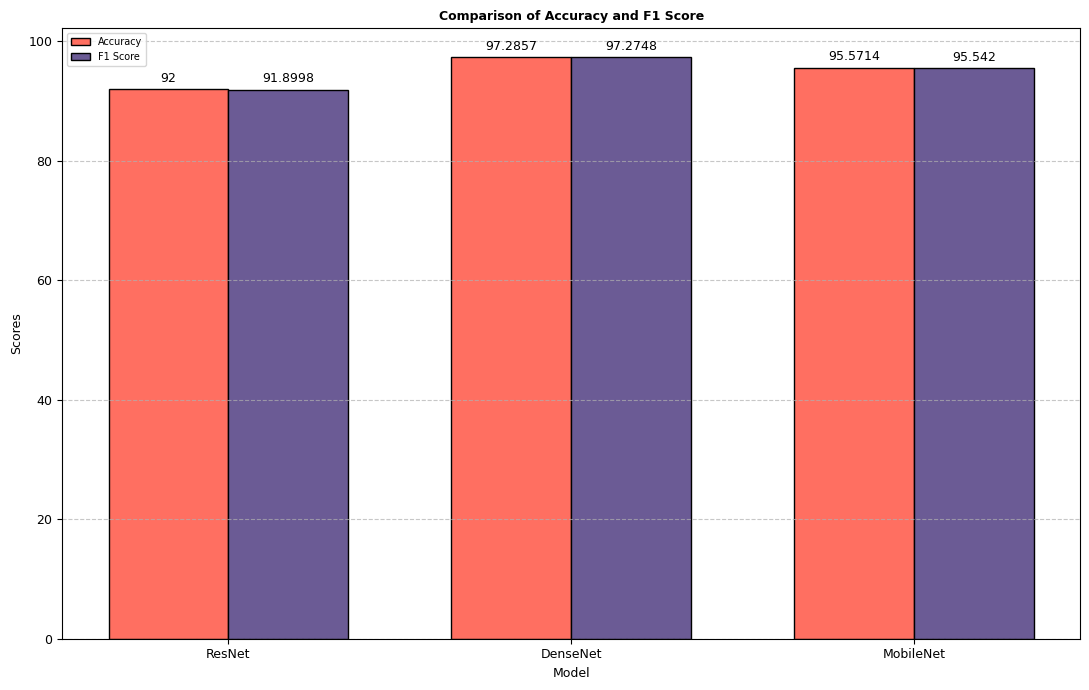

In [ ]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

labels = list(results.keys())
accuracy_values = [results[label]['accuracy'] * 100 for label in labels]  # Multiply accuracy by 100
f1_values = [results[label]['f1_score']*100 for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Define a cute color palette
colors = {
    'Accuracy': '#FF6F61',  # Coral
    'F1 Score': '#6B5B95'   # Purple
}

fig, ax = plt.subplots()
ax.figure.set_size_inches(11, 7)
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy', color=colors['Accuracy'], edgecolor='black')
rects2 = ax.bar(x + width/2, f1_values, width, label='F1 Score', color=colors['F1 Score'], edgecolor='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model', fontsize=9)
ax.set_ylabel('Scores', fontsize=9)
ax.set_title('Comparison of Accuracy and F1 Score', fontsize=9, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=9)

# Add cute elements to the bar chart
ax.bar_label(rects1, padding=3, fontsize=9)
ax.bar_label(rects2, padding=3, fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(loc='upper left', fontsize=7)
plt.show()

In [14]:
# Save the DenseNet model in ONNX format
densenet_model = models_dict['DenseNet']
dummy_input = torch.randn(1, 3, 224, 224, device=device)

onnx_model_path = 'densenet.onnx'
torch.onnx.export(densenet_model, dummy_input, onnx_model_path, 
                  input_names=['input'], output_names=['output'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

print(f"DenseNet model has been saved to {onnx_model_path}")

DenseNet model has been saved to densenet.onnx


In [13]:
import streamlit as st
import onnxruntime as ort
from PIL import Image
import numpy as np

import torchvision.transforms as transforms

# Load the ONNX model
onnx_model_path = 'densenet.onnx'
ort_session = ort.InferenceSession(onnx_model_path)

# Define the transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess the image
def preprocess(image):
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.numpy()

# Streamlit app
st.title("Image Classification with DenseNet ONNX Model")
uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Preprocess the image
    input_image = preprocess(image)

    # Run the model
    ort_inputs = {ort_session.get_inputs()[0].name: input_image}
    ort_outs = ort_session.run(None, ort_inputs)

    # Get the predicted class
    pred_class = np.argmax(ort_outs[0], axis=1)[0]

    # Display the result
    st.write(f"Predicted Class: {dataset.classes[pred_class]}")

2025-03-24 01:25:35.165 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 01:25:35.214 
  command:

    streamlit run /home/kafi/miniforge3/envs/mango/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-24 01:25:35.216 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 01:25:35.217 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 01:25:35.217 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 01:25:35.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 01:25:35.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-24 01:25:35.219 Thre